In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

In [2]:
# X["zip_code"] =  X["zip_code"].str.extract(r"(\d+)")
# numeric_columns = X.select_dtypes(include=np.number).columns.tolist()
# cat_columns     = X.select_dtypes(include=np.object).columns.tolist()
# numeric_pipeline = make_pipeline(SimpleImputer(strategy='mean'), StandardScaler())
# cat_pipeline     = make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder())
# transformers = [('num', numeric_pipeline, numeric_columns),
#                 ('cat', cat_pipeline, cat_columns)]
# transformers = ColumnTransformer(transformers,remainder='passthrough')
# transformer =  ColumnTransformer( [ ('X', OneHotEncoder(sparse="False", categories='auto'),
#                                       ["sub_grade","grade"])],remainder='passthrough')
# train_X =pd.DataFrame(transformer.fit_transform(X))
# train_X = train_X.apply(pd.to_numeric)

In [3]:
def preprocess_data(dataset):
    dataset.columns = dataset.columns.str.strip()
    dataset = dataset.drop(['batch_enrolled','desc','pymnt_plan','initial_list_status',
             'home_ownership','verification_status','application_type',"addr_state","zip_code",
                        "purpose","verification_status_joint","emp_title","title","grade","sub_grade"],axis=1)
    X = dataset.copy()
    #--------------------------------------------------------------------------------------
    '''
    Data Cleaning : After importing the dataset the first operations performed. 
    -> Remove all the unwanted characters from a string. 
    -> Employment length : removing all characters aA-zZ and ><=
    -> last_week_pay : stripping the string- "months" and just keeping the integer values.
    '''
    
    X['emp_length'].replace(to_replace='< 1 year', value='0', regex=True, inplace=True)
    X["emp_length"] = X["emp_length"].str.extract(r"(\d+)")
    X["term"] = X["term"].str.extract(r"(\d+)")
    X["last_week_pay"] =  X["last_week_pay"].str.extract(r"(\d+)")
    #--------------------------------------------------------------------------------------
    
    '''
    The major step in data preprocessing is dealing with missing data.
    In this section, the missing data columns are filled with mean average values. 
    As the missing data numbers were huge, I could not directly remove all the rows. Instead simply 
    imputing the data would prepare the model better. 
    
    - Over the time span of observation, we will fill out missing values with the mean of the variable. 
    - Simple to measure and comprehend. A good alternative if you realize that the variables are usually distributed.
    - Replace missing data with NaN and later take the mean. 
    '''
    df = X.copy()
    df = df.replace("?",np.NaN)
    imputer = SimpleImputer(missing_values = np.NaN, strategy='mean')
    imputer.fit(df)
    df = pd.DataFrame(imputer.transform(df),columns = df.columns)
    #---------------------------------------------------------------------------------------------------------------
    '''
    Creating few more features with existing data in order the model to perform well. 
    Calculating....
    1. interest paid so far using total interest received till date and Late fee received till date
    2. Emi Paid till date: last week pay and total term (Ref: https://economictimes.indiatimes.com/analysis/what-is-emi-and-how-is-it-calculated/articleshow/39880530.cms?from=mdr)
    3. Total repayment = EMI + (Recovered amount / loan amount)
    '''
    #df['avg_acc_line_credits'] = df['total_acc'] - df['open_acc']
    df['interest_paid'] = df['total_rec_int'] + df['total_rec_late_fee']
    df['emi_paid'] = ((df['last_week_pay']/(df['term']/12*52+1))*100)
    df['total_repayment_progress'] = ((df['last_week_pay']/(df['term']/12*52+1))*100) + ((df['recoveries']/df['funded_amnt_inv']) * 100)
     
    
    #--------------------------------------------------------------------------------------------------------------
    '''
    Columns such as acc_now_delinq, total_rec_late_fee, funded_amnt_inv, recoveries, collection_recovery_fee, collections_12_mths_ex_med
    Each of these features show that the repayment was not all easy. All the sums calculated are percentages, 
    such as the sum of the loan recovery. This column provides the extent of how far the recovery in terms of ratios has
    gone off track.
    Negative remark shows if the things have gone off track, that means the person shouldn't have been given loan. 
    '''
    cols = ['acc_now_delinq', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'collections_12_mths_ex_med']
    df[cols].fillna(0, inplace=True)  
    #df['loan_to_income'] = df['annual_inc']/df['funded_amnt_inv']
    
    df['negative_remarks'] = df['acc_now_delinq'] + (df['total_rec_late_fee']/df['funded_amnt_inv']) 
    (df['recoveries']/df['funded_amnt_inv']) + (df['collection_recovery_fee']/df['funded_amnt_inv'])
    + (df['collections_12_mths_ex_med']/df['funded_amnt_inv'])
    df.loc[df['negative_remarks'] > 0, 'negative_remarks'] = 1
    
    #----------------------------------------------------------------------------------------------------------------
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.dropna()
    return df

In [4]:
train = pd.read_csv("train_indessa.csv")
test = pd.read_csv("test_indessa.csv")

#### The below figures show the missing values in the entire dataset before Data-Preprocessing 

In [5]:
train.isnull().sum()

member_id                           0
loan_amnt                           0
funded_amnt                         0
funded_amnt_inv                     0
term                                0
batch_enrolled                  85149
int_rate                            0
grade                               0
sub_grade                           0
emp_title                       30833
emp_length                      26891
home_ownership                      0
annual_inc                          3
verification_status                 0
pymnt_plan                          0
desc                           456829
purpose                             0
title                              90
zip_code                            0
addr_state                          0
dti                                 0
delinq_2yrs                        16
inq_last_6mths                     16
mths_since_last_delinq         272554
mths_since_last_record         450305
open_acc                           16
pub_rec     

In [6]:
train_data = preprocess_data(train)
test = preprocess_data(test)

c:\users\wasee\miniconda3\lib\site-packages\pandas\core\frame.py:4327: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,
c:\users\wasee\miniconda3\lib\site-packages\pandas\core\frame.py:4327: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


#### The below figures show the missing values in the entire dataset "after Data-Preprocessing"

In [7]:
train_data.isnull().sum()

member_id                      0
loan_amnt                      0
funded_amnt                    0
funded_amnt_inv                0
term                           0
int_rate                       0
emp_length                     0
annual_inc                     0
dti                            0
delinq_2yrs                    0
inq_last_6mths                 0
mths_since_last_delinq         0
mths_since_last_record         0
open_acc                       0
pub_rec                        0
revol_bal                      0
revol_util                     0
total_acc                      0
total_rec_int                  0
total_rec_late_fee             0
recoveries                     0
collection_recovery_fee        0
collections_12_mths_ex_med     0
mths_since_last_major_derog    0
last_week_pay                  0
acc_now_delinq                 0
tot_coll_amt                   0
tot_cur_bal                    0
total_rev_hi_lim               0
loan_status                    0
interest_p

In [8]:
train_data.head()

,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,emp_length,annual_inc,dti,delinq_2yrs,...,last_week_pay,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,loan_status,interest_paid,emi_paid,total_repayment_progress,negative_remarks
0,58189336.0,14350.0,14350.0,14350.0,36.0,19.19,9.0,28700.0,33.88,0.0,...,26.0,0.0,0.0,28699.0,30800.0,0.0,1173.84,16.560510,16.560510,0.0
1,70011223.0,4800.0,4800.0,4800.0,36.0,10.99,0.0,65000.0,3.64,0.0,...,9.0,0.0,0.0,9974.0,32900.0,0.0,83.95,5.732484,5.732484,0.0
2,70255675.0,10000.0,10000.0,10000.0,36.0,7.26,2.0,45000.0,18.42,0.0,...,9.0,0.0,65.0,38295.0,34900.0,0.0,56.47,5.732484,5.732484,0.0
3,1893936.0,15000.0,15000.0,15000.0,36.0,19.72,10.0,105000.0,14.97,0.0,...,135.0,0.0,0.0,55564.0,24700.0,0.0,4858.62,85.987261,85.987261,0.0
4,7652106.0,16000.0,16000.0,16000.0,36.0,10.64,10.0,52000.0,20.16,0.0,...,96.0,0.0,0.0,47159.0,47033.0,0.0,2296.41,61.146497,61.146497,0.0


# Visualization data


Text(0, 0.5, 'Percentage')

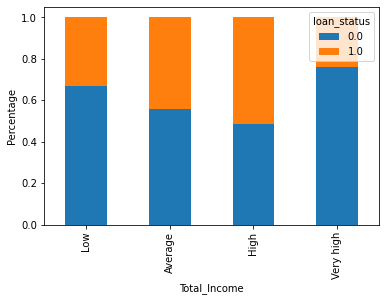

In [9]:
Annual_income = train_data['annual_inc']
bins =[0,2500,4000,6000,81000]
group =['Low','Average','High','Very high']
Annual_income['annual_inc'] = pd.cut(train_data['annual_inc'],bins,labels=group)
Total_Income_bin=pd.crosstab(Annual_income['annual_inc'],train_data['loan_status'])
Total_Income_bin.div(Total_Income_bin.sum(1).astype(float), axis=0).plot(kind="bar",stacked=True)
plt.xlabel('Total_Income')
plt.ylabel('Percentage')

We can see that the proportion of approved loans for low-total-income applicants is much satisfactory than that of Average, High & Very High Income applicants.

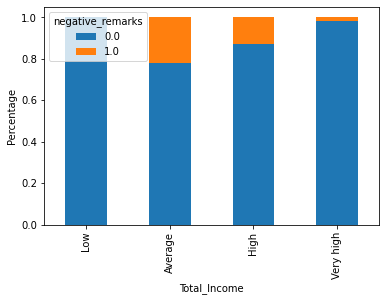

In [10]:
bins =[0,2500,4000,6000,81000]
group =['Low','Average','High','Very high']
Annual_income['annual_inc'] = pd.cut(train_data['annual_inc'],bins,labels=group)
Total_Income_bin=pd.crosstab(Annual_income['annual_inc'],train_data['negative_remarks'])
Total_Income_bin.div(Total_Income_bin.sum(1).astype(float), axis=0).plot(kind="bar",stacked=True)
plt.xlabel('Total_Income')
P=plt.ylabel('Percentage')

The above graph is plotted with Total Annual income and negative remarks calculated based on the delinquency. This is how much the loans were to be approved by the bank. The people with low income should be kept on hold or not be provided with any loan unless provide mortgage. The people with very high income are the ones who have large deliquency and we should be careful while giving the loan. 

In [11]:
plot = train_data[['negative_remarks','interest_paid','emi_paid','total_repayment_progress']]
plot.head()

,negative_remarks,interest_paid,emi_paid,total_repayment_progress
0,0.0,1173.84,16.560510,16.560510
1,0.0,83.95,5.732484,5.732484
2,0.0,56.47,5.732484,5.732484
3,0.0,4858.62,85.987261,85.987261
4,0.0,2296.41,61.146497,61.146497


<AxesSubplot:>

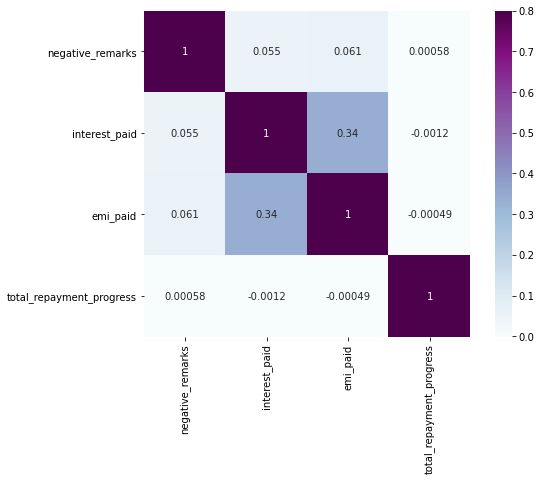

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

matrix = plot.corr()
f, ax = plt.subplots(figsize=(9,6))
sns.heatmap(matrix,vmax=.8,square=True,cmap="BuPu", annot = True)

The above plot has the values calculated using the existing data. We see that the most correlated variables are (Emi paid - Interest paid). These two facors turn to build the model better. 

# Model Building 

In [13]:
'''
Split the training data into train and validation sets. Initializing the features and targets. 
'''
train_X = train_data.drop(columns=['member_id','loan_status'])
train_y = train_data["loan_status"]
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, test_size=0.30)
eval_set=[(X_test, y_test)]

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
'''
The first classifier we will train and test our model is Logistic Regression. 
'''
reg = LogisticRegression()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
acc_score = accuracy_score(y_test,y_pred)
acc_roc_auc = roc_auc_score(y_test, y_pred)
FP_LR, TP_LR, _ = roc_curve(y_test, y_pred)
print("Accuracy: %.10f%%" % (acc_score * 100.0))
print("ROC-AUC: %.10f%%" % (acc_roc_auc * 100))

Accuracy: 76.7589096169%
ROC-AUC: 51.1858658979%


c:\users\wasee\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [15]:
'''
The second classifier we will train and test our model is XGBoost Classifier. 
XGBoost is a decision-tree-based ensemble Machine Learning algorithm that uses a gradient boosting framework.
For small-to-medium structured/tabular data, decision tree based algorithms are considered best-in-class right now. 
'''
import xgboost

print("Running XGBoost classifier. This would take some time....")
clf = xgboost.sklearn.XGBClassifier( objective="binary:logistic", learning_rate=0.05, seed=9616, max_depth=20, gamma=10, 
    n_estimators=500)

clf.fit(X_train, y_train, early_stopping_rounds=20, eval_metric="auc", eval_set=eval_set, verbose = False)
print("---------- Model Built -------------")
print("Predicting ...")

y_pred = clf.predict(X_test)


accuracy = accuracy_score(np.array(y_test).flatten(), y_pred)
print("Accuracy: %.10f%%" % (accuracy * 100.0))

accuracy_per_roc_auc = roc_auc_score(np.array(y_test).flatten(), y_pred)
print("ROC-AUC: %.10f%%" % (accuracy_per_roc_auc * 100))
FP_XG, TP_XG, _ = roc_curve(y_test, y_pred)


c:\users\wasee\miniconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Running XGBoost classifier. This would take some time....
---------- Model Built -------------
Predicting ...
Accuracy: 90.6955481661%
ROC-AUC: 82.8068028486%


# Vizualizing the results 

In [16]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
confusion_matrix(y_test,y_pred)

array([[119277,   2768],
       [ 12090,  25552]], dtype=int64)

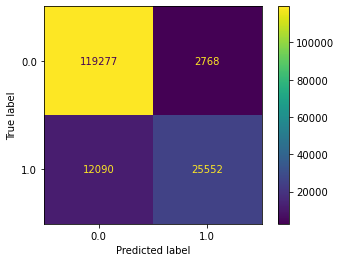

In [17]:
plot_confusion_matrix(clf, X_test, y_test)
plt.show()

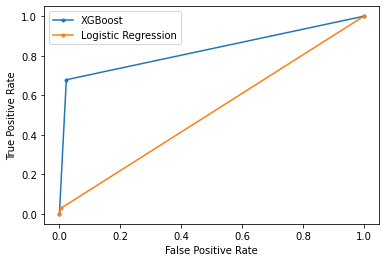

In [18]:

from matplotlib import pyplot
# plot the roc curve for the model
pyplot.plot(FP_XG, TP_XG, marker='.', label='XGBoost')
pyplot.plot(FP_LR, TP_LR, marker='.', label='Logistic Regression')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

## Predicting the test dataset and saving the results 

In [19]:
test_member_id = test['member_id']
test = test.drop(columns=['member_id'])
print("Predicting probabilities of test data ...")
test_data_pred = pd.DataFrame(clf.predict_proba(np.array(test)))
file = 'Final_Submission'
print("Saving probabilities of test data into an excel sheet...")
excel_file = pd.concat([test_member_id, test_data_pred.loc[:, 1:2]], axis=1)
excel_file.rename(columns={1:'loan_status'}, inplace=True)
excel_file.to_csv((('%s.csv') % (file)), index=False)

Predicting probabilities of test data ...
Saving probabilities of test data into an excel sheet...
